In [1]:
%matplotlib agg
import itertools
from collections import OrderedDict

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.spatial
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import tqdm
import torch
import tables
import torchgraphs as tg

from IPython.display import display, Markdown

aminoacids = ['-', 'A', 'C', 'B', 'E', 'D', 'G', 'F', 'I', 'H', 'K', 'M', 'L', 'N', 'Q', 'P', 'S', 'R', 'T', 'W', 'V', 'Y']
h5_file = tables.open_file('../data/CASP9.h5')

## All proteins

In [2]:
from proteins.utils import RunningStats

#all_distances = RunningStats()
all_neighbor_distances = RunningStats()
all_local_scores = []
all_global_scores = []
for protein in h5_file.list_nodes('/'):
    all_global_scores += np.array(protein.gdt_ts).tolist()
    all_local_scores += np.array(protein.lddt).ravel().tolist()
    for model_idx in range(len(protein.names)):
        coordinates = protein.cb_coordinates[model_idx]  # coordinates of the β carbon (or α if β is not present)
        # distances = scipy.spatial.distance.pdist(coordinates)  # flattened pairwise distances between residues
        # all_distances.add_from(distances)
        neighbor_distances = np.sqrt(np.sum(np.square(coordinates[:-1] - coordinates[1:]), axis=1))
        all_neighbor_distances.add_from(neighbor_distances[~np.isnan(neighbor_distances)])

#print(all_distances)
print(all_neighbor_distances)

5.347898313473701 ± 0.9728933454997792 (min: 0.012042107991874218, max: 375.2893371582031, count: 7382555)


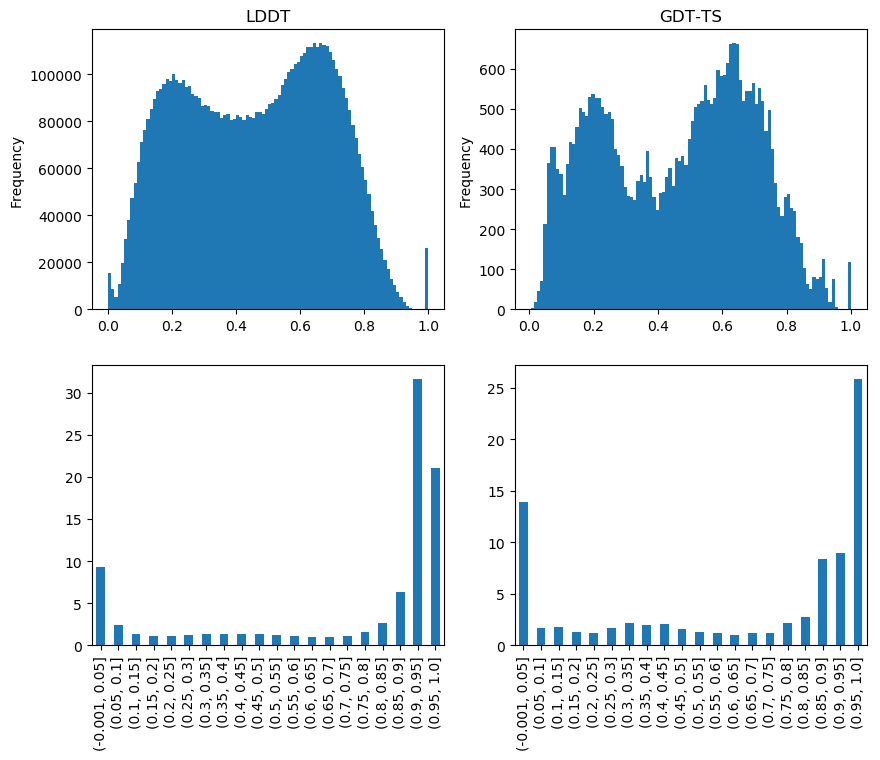

In [3]:
all_local_scores = pd.Series(all_local_scores, name='local_scores').dropna()
all_global_scores = pd.Series(all_global_scores, name='global_scores').dropna()

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
all_local_scores.plot.hist(bins=100, title='LDDT', ax=axes[0, 0])
all_global_scores.plot.hist(bins=100, title='GDT-TS', ax=axes[0, 1])

frequencies_local = pd.cut(all_local_scores, bins=np.linspace(0, 1, num=20+1), include_lowest=True) \
    .value_counts() \
    .sort_index()
frequencies_global = pd.cut(all_global_scores, bins=np.linspace(0, 1, num=20+1), include_lowest=True) \
    .value_counts() \
    .sort_index()

(frequencies_local.max() / frequencies_local).plot.bar(ax=axes[1, 0])
(frequencies_global.max() / frequencies_global).plot.bar(ax=axes[1, 1])
display(fig)

## Protein T0538
Here we have the target T0538 of length 54 and with 280 models (the native structure plus 279 models). 
- dssp contains the structural inputs (secondary structure and torsion angles)
- lddt is the local quality scores
- seq, part_entr and self_info are the sequence information (common to all of them).
- valid_dssp is a boolean vector that indicates if the residue is present in the model (some models have missing residues)
- valid indicates if the residue is present in the experimental structure, hence we can know its actual quality. Some residues are missing, so we just ignore those.

In [4]:
protein = h5_file.get_node('/T0538')

sequence_len = protein.seq.shape[1]
num_models = len(protein.names)

pd.Series([field.shape for field in protein], index=[field.name for field in protein])

cb_coordinates     (289, 54, 3)
dssp              (289, 54, 14)
gdt_ts                   (289,)
gdt_ts_ha                (289,)
lddt                  (289, 54)
lddt_global              (289,)
max_sub                  (289,)
names                    (289,)
part_entr           (1, 54, 23)
rmsd                     (289,)
s_scores              (289, 54)
self_info           (1, 54, 23)
seq                 (1, 54, 22)
valid                 (289, 54)
valid_dssp            (289, 54)
dtype: object

### Sequential features

This sequence is the sequence of amino acids that were found in the experiment that determined the native structure.

In the case, the experiment determined a sequence of 54 amino acid, but was only able to determine the structure of 53 of them. The first residue does not have a determined position and therefore does not have DSSP properties.

In [5]:
print(' '.join(aminoacids[i - 1] for i in np.argmax(protein.seq[0], axis=1)))
print(' '.join('^' if v else ' ' for v in protein.valid[0]))

H M K P R S Q C Y I S I K I M G N D D Y P Q L Y I Y P G C L K Y P L Y C L B G T S N C K T C L Y P K C D E L
  ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^


Multiple-sequence alignment features: Self information and Partial Entropy

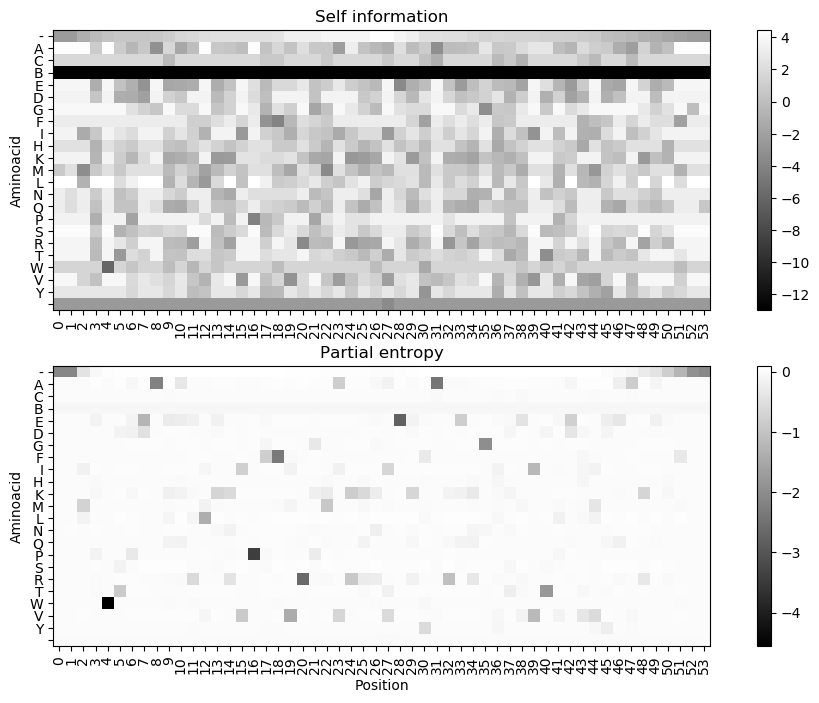

In [6]:
fig = plt.figure(figsize=(12, 8))
gs = plt.GridSpec(2, 1)

ax = fig.add_subplot(gs[0, 0])
img = ax.imshow(protein.self_info[0].T, cmap='gray')
ax.set_yticks(np.arange(23))
ax.set_yticklabels(aminoacids)
ax.set_ylabel('Aminoacid')
ax.set_xticks(np.arange(len(protein.seq[0])))
ax.set_xticklabels(np.arange(len(protein.seq[0])), rotation=90)
ax.set_title('Self information')

fig.colorbar(img, ax=ax)

ax = fig.add_subplot(gs[1, 0])
img = ax.imshow(protein.part_entr[0].T, cmap='gray')
ax.set_yticks(np.arange(23))
ax.set_yticklabels(aminoacids)
ax.set_ylabel('Aminoacid')
ax.set_xticks(np.arange(len(protein.seq[0])))
ax.set_xticklabels(np.arange(len(protein.seq[0])), rotation=90)
ax.set_xlabel('Position')
ax.set_title('Partial entropy')

fig.colorbar(img, ax=ax)

display(fig)

#### LDDT scores

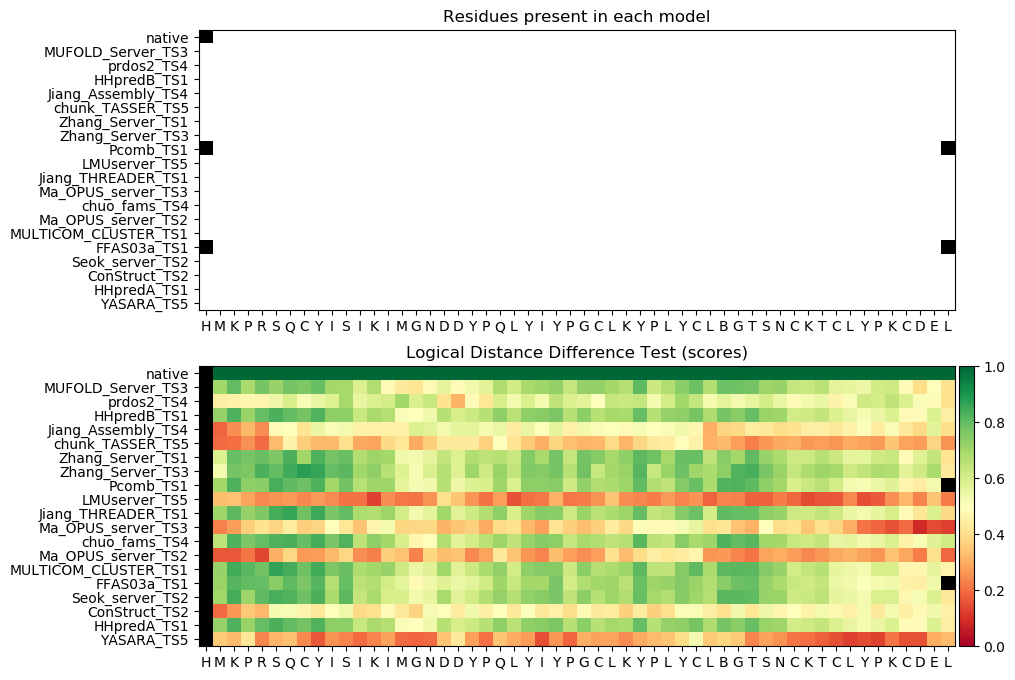

In [7]:
fig = plt.figure(figsize=(10, 8))
gs = plt.GridSpec(2, 2, width_ratios=[50, 1], wspace=0.01)

ax = fig.add_subplot(gs[0, :-1])
ax.imshow(protein.valid_dssp[:20], cmap='gray')
ax.set_yticks(np.arange(20))
ax.set_yticklabels([n.decode('utf-8') for n in protein.names[:20]])
ax.set_xticks(np.arange(len(protein.seq[0])))
ax.set_xticklabels([aminoacids[i - 1] for i in np.argmax(protein.seq[0], axis=1)])
ax.set_title('Residues present in each model')

ax = fig.add_subplot(gs[1, :-1], sharex=ax)
img = ax.imshow(np.ma.masked_where(np.logical_not(protein.valid[:20]), protein.lddt[:20]), cmap='RdYlGn', vmin=0, vmax=1)
ax.imshow(np.ma.masked_where(protein.valid[:20], np.zeros_like(protein.lddt[:20])), cmap='gray')
ax.set_yticks(np.arange(20))
ax.set_yticklabels([n.decode('utf-8') for n in protein.names[:20]])
ax.set_xticks(np.arange(len(protein.seq[0])))
ax.set_xticklabels([aminoacids[i - 1] for i in np.argmax(protein.seq[0], axis=1)])
ax.set_title('Logical Distance Difference Test (scores)')

ax = fig.add_subplot(gs[1, -1])
fig.colorbar(img, cax=ax)

display(fig)

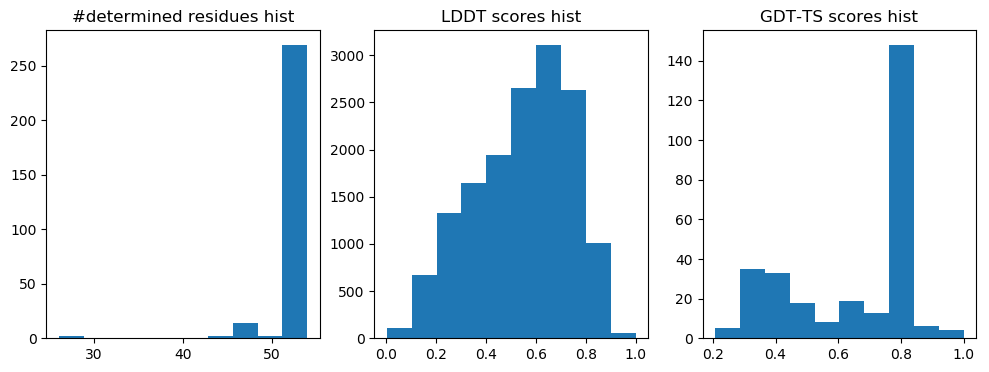

In [8]:
fig = plt.figure(figsize=(12, 4))
gs = plt.GridSpec(1, 3)

ax = fig.add_subplot(gs[0])
ax.hist(np.array(protein.valid_dssp).sum(axis=1))
ax.set_title('#determined residues hist')

ax = fig.add_subplot(gs[1])
ax.hist(np.array(protein.lddt)[np.array(protein.valid)])
ax.set_title('LDDT scores hist')

ax = fig.add_subplot(gs[2])
ax.hist(np.array(protein.gdt_ts))
ax.set_title('GDT-TS scores hist')

display(fig)

### Decoys - 3D models

#### Decoy 0: native
One residue from the sequence was not modeled

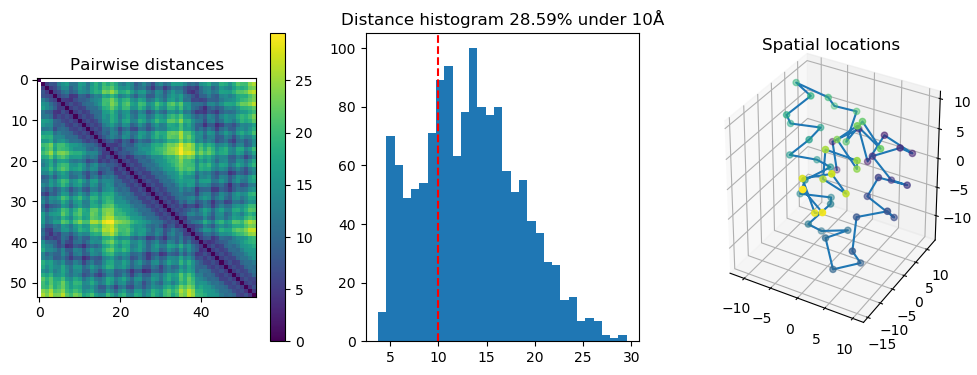

#### Decoy 2: prdos2_TS4
Models all residues from the sequence, also one whose position was not determined in the native structure

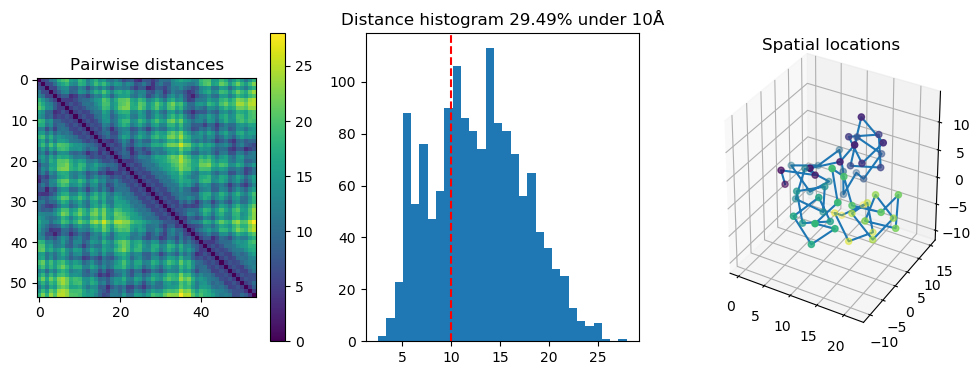

#### Decoy 10: Jiang_THREADER_TS1
Fails to model many of the residues present in the native structure

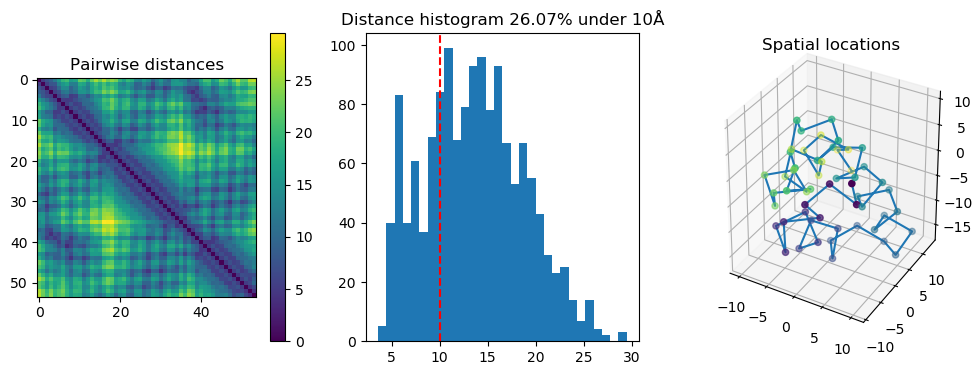

In [9]:
columns = pd.MultiIndex(
    levels=[
        ['amino-acid', 'dssp','decoy'],
        ['', '3-state','6-state', 'surface acc', 'φ', 'ψ', 'coords', 'lddt'],
    ],
    codes=[
        [0, 1, 1, 1, 1, 1, 2, 2],
        [0, 1, 2, 3, 4, 5, 6, 7],
    ]
)

for model_idx, comment in {
    0: 'One residue from the sequence was not modeled',
    2: 'Models all residues from the sequence, also one whose position was not determined in the native structure',
    10: 'Fails to model many of the residues present in the native structure',
}.items():
    # Protein sequence and multi-sequence-alignment features, common to all models
    residues = protein.seq[0]                # One-hot encoding of the residues present in this model
    partial_entropy = protein.part_entr[0]   # Partial entropy of the residues
    self_information = protein.self_info[0]  # Self information of the residues
    sequence_length = len(residues)

    # Secondary structure is determined using some method by some research group.
    # All models use the original sequence as source, but can fail to determine a structure for some residues.
    # The DSSP features are extracted for the residues whose 3D coordinates are determined.
    provider = protein.names[model_idx].decode('utf-8')    # Who built this model of the protein
    coordinates = protein.cb_coordinates[model_idx]        # Coordinates of the β carbon (α if β is not present)
    distances = scipy.spatial.distance.pdist(coordinates)  # Pairwise distances between residues
    structure_determined = protein.valid_dssp[model_idx]   # Which residues are determined within this model
    dssp_features = protein.dssp[model_idx]                # DSSP features for the secondary structure

    coordinates = protein.cb_coordinates[model_idx]  # coordinates of the β carbon (or α if β is not present)
    distances = scipy.spatial.distance.pdist(coordinates)          # pairwise distances between residues

    # For every residue, local and global scores are determined by comparison with the native structure.
    # It is not possible to assign a local score to a residue if:
    # - the native model of the protein determined experimentally has failed to
    #   _observe_ the secondary structure of that residue
    # - the current model of the protein has failed to _determine_ the secondary structure of that residue
    valid_scores = protein.valid[model_idx]
    scores = protein.lddt[model_idx]               # Quality scores of the residues
    global_score = protein.lddt_global[model_idx]  # Quality score of the whole model
    
    display(Markdown(f'#### Decoy {model_idx}: {provider}\n{comment}'))
    
    df = pd.DataFrame({
        'amino-acid': [aminoacids[i - 1] for i in np.argmax(residues, axis=1)],
        '3-state': ['HEC'[s] if valid else '-' for s, valid in zip(np.argmax(dssp_features[:, :3], axis=1), structure_determined)],
        '6-state': ['GI,H,E,B,TS,C'.split(',')[s] if valid else '-' for s, valid in zip(np.argmax(dssp_features[:, 3:3+6], axis=1), structure_determined)],
        'surface acc': np.where(structure_determined, dssp_features[:, 9], np.nan),
        'φ': np.where(structure_determined, np.degrees(np.arctan2(dssp_features[:, 10], dssp_features[:, 11])), np.nan),
        'ψ': np.where(structure_determined, np.degrees(np.arctan2(dssp_features[:, 12], dssp_features[:, 13])), np.nan), 
        'coords': [f'{x:.1f}, {y:.1f}, {z:.1f}' if not np.isnan(x) else '-' for x, y, z in coordinates],
        'lddt': np.where(valid_scores, scores, np.nan)
    })
    df.columns = columns

    display(
        df
        .style
        .format({'surface acc': '{:.2%}', 'φ': '{:.1f}', 'ψ': '{:.1f}'})
        .apply(lambda _: np.where(structure_determined, '', 'color: red'), subset=pd.IndexSlice[:, ['dssp']], axis='index')
        .apply(lambda _: np.where(structure_determined, '', 'color: red'), subset=pd.IndexSlice[:, pd.IndexSlice['decoy', 'coords']], axis='index')
        .apply(lambda _: np.where(structure_determined, '', 'color: red'), subset=pd.IndexSlice[:, pd.IndexSlice['decoy', 'lddt']], axis='index')
        .bar(subset=pd.IndexSlice[:, pd.IndexSlice['decoy', 'lddt']], color='green', vmin=0, vmax=1)
        .bar(subset=pd.IndexSlice[:, pd.IndexSlice['dssp', 'surface acc']], color='pink', vmin=0, vmax=1)
        .bar(subset=pd.IndexSlice[:, pd.IndexSlice['dssp', 'φ']], color=['turquoise', 'orange'], align='zero', vmin=-180, vmax=180)
        .bar(subset=pd.IndexSlice[:, pd.IndexSlice['dssp', 'ψ']], color=['turquoise', 'orange'], align='zero', vmin=-180, vmax=180)
    )

    fig = plt.figure(figsize=(12, 4))
    gs = plt.GridSpec(1, 3)

    ax = fig.add_subplot(gs[0])
    img = ax.imshow(scipy.spatial.distance.squareform(distances))
    ax.set_title('Pairwise distances')
    plt.colorbar(img, ax=ax)

    ax = fig.add_subplot(gs[1])
    ax.hist(distances[~np.isnan(distances)], bins=30);
    ax.axvline(10, color='red', linestyle='--')
    ax.set_title(f'Distance histogram {(distances[~np.isnan(distances)] < 10).sum() / np.count_nonzero(~np.isnan(distances)):.2%} under 10Å')
    
    ax = fig.add_subplot(gs[2], projection='3d')
    ax.plot(*coordinates.T);
    ax.scatter(*coordinates.T, c=np.linspace(0,1,len(coordinates)));
    ax.set_title('Spatial locations')

    display(fig)

### Build graph

Normalization for distances:
- neighboring residues are at around 5Å
- after 10Å the influence is negligible

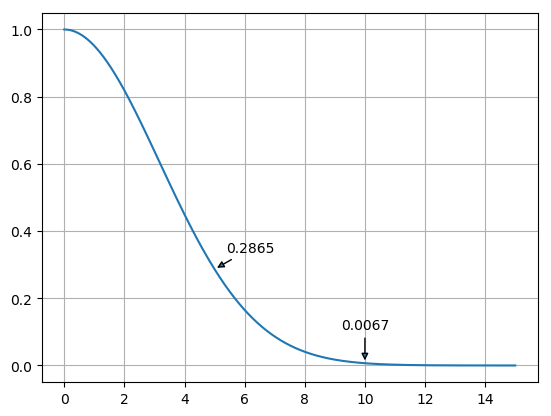

In [10]:
x = np.linspace(0,15, 10000)
f = lambda x: np.exp(-x**2 / 20)
y = f(x)
fig, ax = plt.subplots(1,1)
ax.plot(x, y)
ax.annotate(f'{f(5):.4f}', (5, f(5)), xytext=(5+.4, f(5) + .05), arrowprops={'arrowstyle': '-|>'})
ax.annotate(f'{f(10):.4f}', (10, f(10)), xytext=(10 - .8, f(10) + .1), arrowprops={'arrowstyle': '-|>'})
ax.grid()
display(fig)

In [11]:
model_idx = 10

# Protein sequence and multi-sequence-alignment features, common to all models
residues = protein.seq[0]                # One-hot encoding of the residues present in this model
partial_entropy = protein.part_entr[0]   # Partial entropy of the residues
self_information = protein.self_info[0]  # Self information of the residues
sequence_length = len(residues)

# Secondary structure is determined using some method by some research group.
# All models use the original sequence as source, but can fail to determine a structure for some residues.
# The DSSP features are extracted for the residues whose 3D coordinates are determined.
provider = protein.names[model_idx].decode('utf-8')    # Who built this model of the protein
coordinates = protein.cb_coordinates[model_idx]        # Coordinates of the β carbon (α if β is not present)
distances = scipy.spatial.distance.pdist(coordinates)  # Pairwise distances between residues
structure_determined = protein.valid_dssp[model_idx]   # Which residues are determined within this model
dssp_features = protein.dssp[model_idx]                # DSSP features for the secondary structure

# For every residue, local and global scores are determined by comparison with the native structure.
# It is not possible to assign a local score to a residue if:
# - the native model of the protein determined experimentally has failed to
#   _observe_ the secondary structure of that residue
# - the current model of the protein has failed to _determine_ the secondary structure of that residue
valid_scores = protein.valid[model_idx]
scores = protein.lddt[model_idx]          # Quality scores of the residues
global_score = protein.gdt_ts[model_idx]  # Quality score of the whole model

# Distances above 10 Angstrom are not considered relevant
# Missing distances between connected residues are set to an average distance
senders, receivers = np.triu_indices(sequence_length, k=1)
to_fill = np.logical_and(receivers - senders == 1, np.isnan(distances))
distances[to_fill] = np.random.normal(5.350942490574513, 0.9335879838891673, np.count_nonzero(to_fill))
with np.errstate(invalid='ignore'): 
    has_effect = distances < 10

senders = senders[has_effect]
receivers = receivers[has_effect]
distances = distances[has_effect]
distances = np.exp((distances - 5) * np.log(.01) / 5)

graph_in = tg.Graph(
    num_nodes=sequence_length,
    node_features=torch.from_numpy(np.concatenate([
        residues,
        partial_entropy,
        self_information,
        dssp_features,
        structure_determined[:, None]
    ], axis=1)).float(),
    senders=torch.from_numpy(np.concatenate((senders, receivers))),
    receivers=torch.from_numpy(np.concatenate((receivers, senders))),
    edge_features=torch.from_numpy(f(distances)).repeat(2).view(-1, 1).float()
)
graph_target = tg.Graph(
    num_nodes=sequence_length,
    node_features=torch.from_numpy(scores).view(-1, 1).float(),
    global_features=torch.tensor([global_score]).float()
)

graph_in, graph_target

(Graph(n=54, e=746, n_shape=torch.Size([83]), e_shape=torch.Size([1]), g_shape=None),
 Graph(n=54, e=0, n_shape=torch.Size([1]), e_shape=None, g_shape=torch.Size([1])))